# Setup enviorment

In [1]:
import os
import logging
import tensorflow as tf
# Set TensorFlow logging level to suppress debug messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '0' (default) shows all logs, '1' shows only warnings and errors, '2' shows only errors
# Disable logging of debug messages from TensorFlow
tf.get_logger().setLevel(logging.ERROR)

from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import numpy as np

2023-06-15 13:05:08.734492: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 13:05:08.771760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 13:05:08.772893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 13:05:09.676325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder/variational_autoencoder_ResNet50V2__224_1024_12Bands.csv'
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
static = '../Tabular_data/dengue_tabular.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)
fusion = 'joint' # 'joint' # 'early' # 'late' # None

""" Model Parameters:"""
model = 'LSTM' # 'LSTM' # 'GRU' # 'Transformer'

if model == 'Transformer':
    num_transformer_blocks = 2
    lstm_layers = None
    dense_acivation = None
else:
    lstm_layers = [1000, 500]
    dense_acivation = 'relu'
    
nn_layers = [250, 120, 1]
recurrent_cells = model
bidirectional=False


""" Tests: """
n_tests = 5

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe fo

list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.932970  0.875227 -1.729076 -0.321430 -0.033601 -1.172334   
      201547  1.306589 -2.279299  0.548588 -0.006082 -0.634774  0.362475   
      201548 -0.651867 -0.023501 -0.598102  2.005118  0.007778  0.385663   
      201549 -1.588344 -0.316124 -2.456090  0.751120 -0.066712 -0.505668   
      201550  0.925534  1.529721  0.180933  2.270420  1.536550  0.176794   

                     6         7         8         9  ...  \
41001 201546 -1.342734  1.826624 -1.143225  0.003645  ...   
      201547  0.728996  1.391685  0.424425  0.147971  ...   
      201548  0.800452 -1.727848  0.565240  0.019856  ...   
      201549  1.264875 -0.481089 -1.480794 -1.304145  ...   
      201550 -1.855709 -0.201730  1.771857  0.071268  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                   -0.049236                    1.299709   
      201547                   -0.049236                    1.299709   
      201548                   -0.049236                    1.299709   
      201549                   -0.049236                    1.299709   
      201550                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -1.218603                   -0.616395   
      201547                   -1.218603                   -0.616395   
      201548                   -1.218603                   -0.616395   
      201549                   -1.218603                   -0.616395   
      201550                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                    -0.69223                   -0.912227   
      201547                    -0.69223                   -0.912227   
      201548                    -0.69223                   -0.912227   
      201549                    -0.69223                   -0.912227   
      201550                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.835433              -0.74019   -0.773497   
      201547                -0.835433              -0.74019   -0.773497   
      201548                -0.835433              -0.74019   -0.773497   
      201549                -0.835433              -0.74019   -0.773497   
      201550                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201546  0.064361  
      201547  0.091926  
      201548  0.082738  
      201549  0.082738  
      201550  0.211376  

[5 rows x 1051 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -1.068635 -2.290411 -2.234757  1.903720  0.713268 -0.778890   
      201821  1.601019 -0.784144  0.215453 -0.676210 -0.212750  0.645536   
      201822  0.547023  0.362829 -1.363910 -0.243242 -1.433389 -0.458457   
      201823  0.092972 -1.603495  0.234719  0.029002 -0.042293 -0.966330   
      201824 -0.080325  2.108595 -0.824066  0.898747  0.664320  0.441828   

                     6         7         8         9  ...  \
41001 201820  0.326250  0.338378  0.536548  0.984646  ...   
      201821 -0.405809  0.110907  1.254733 -0.464225  ...   
      201822 -1.313660  0.425514  1.526300  0.965010  ...   
      201823  0.900280 -0.903611 -0.831815  0.644353  ...   
      201824 -0.912123  0.831116 -0.037521 -1.211820  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201820                   -0.049236                    1.299709   
      201821                   -0.049236                    1.299709   
      201822                   -0.049236                    1.299709   
      201823                   -0.049236                    1.299709   
      201824                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201820                   -1.218603                   -0.616395   
      201821                   -1.218603                   -0.616395   
      201822                   -1.218603                   -0.616395   
      201823                   -1.218603                   -0.616395   
      201824                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201820                    -0.69223                   -0.912227   
      201821                    -0.69223                   -0.912227   
      201822                    -0.69223                   -0.912227   
      201823                    -0.69223                   -0.912227   
      201824                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201820                -0.835433              -0.74019   -0.773497   
      201821                -0.835433              -0.74019   -0.773497   
      201822                -0.835433              -0.74019   -0.773497   
      201823                -0.835433              -0.74019   -0.773497   
      201824                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201820 -0.275610  
      201821 -0.321552  
      201822 -0.238856  
      201823 -0.321552  
      201824 -0.293986  

[5 rows x 1051 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 3151)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 3151)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 3150)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 3150)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 3150)
The test shape is (310, 3150)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 1050)
The test shape is (310, 3, 1050)


In [13]:
if fusion and (T != 0):
    
    if embeddings and static and temp_prec:
        # Modality 2
        x_ar = train_X[:, :, -28:]
        x_ar_test = test_X[:, :, -28:]
        # Modality 1
        train_X = train_X[:, :, :-28]
        test_X = test_X[:, :, :-28]
    
    if embeddings and static and not(temp_prec):
        # Modality 2
        x_ar = train_X[:, :, -26:]
        x_ar_test = test_X[:, :, -26:]
        # Modality 1
        train_X = train_X[:, :, :-26]
        test_X = test_X[:, :, :-26]
        
    if embeddings and not(static) and temp_prec:
        # Modality 2
        x_ar = train_X[:, :, -2:]
        x_ar_test = test_X[:, :, -2:]
        # Modality 1
        train_X = train_X[:, :, :-2]
        test_X = test_X[:, :, :-2]
else:
    x_ar = None
    x_ar_test = None

# 2. Model

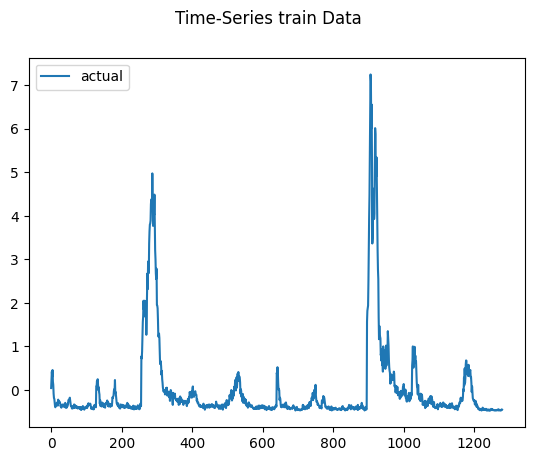

2023-06-15 13:05:19.766976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:05:19.768722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:05:19.769919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_input (InputLayer)        [(None, 3, 1022)]    0           []                               
                                                                                                  
 lstm_2_input (InputLayer)      [(None, 3, 28)]      0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            11252971    ['lstm_input[0][0]']             
                                                                                                  
 sequential_1 (Sequential)      (None, 1)            7276971     ['lstm_2_input[0][0]']           
                                                                                              

2023-06-15 13:09:50.432742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:09:50.435468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:09:50.438870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 2s 18ms/step
Test MAE: 21.732
Test RMSE: 33.989
Test sMAPE: 77.265
Test R Squared: -0.164
{'mae': 21.7316523152013, 'rmse': 33.989175358329256, 'smape': 77.26500498779552, 'r2': -0.16443751908883275}


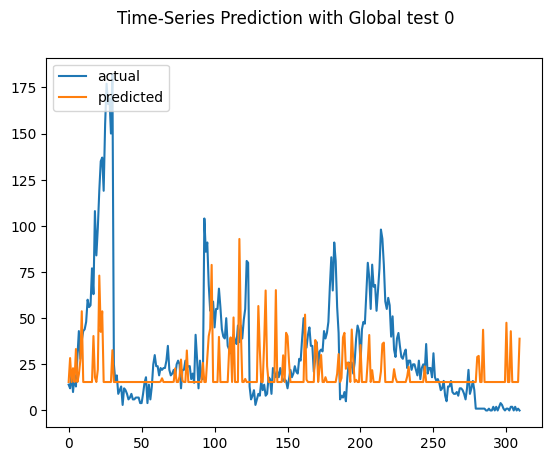

2023-06-15 13:09:52.914791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:09:52.916996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:09:52.918571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_4_input (InputLayer)      [(None, 3, 1022)]    0           []                               
                                                                                                  
 lstm_6_input (InputLayer)      [(None, 3, 28)]      0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 1)            11252971    ['lstm_4_input[0][0]']           
                                                                                                  
 sequential_3 (Sequential)      (None, 1)            7276971     ['lstm_6_input[0][0]']           
                                                                                            

2023-06-15 13:14:05.051030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:14:05.053087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:14:05.054389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 20ms/step
Test MAE: 22.375
Test RMSE: 31.883
Test sMAPE: 74.474
Test R Squared: -0.025
{'mae': 22.37494932605374, 'rmse': 31.883047152445602, 'smape': 74.47380380181909, 'r2': -0.024600532840599598}


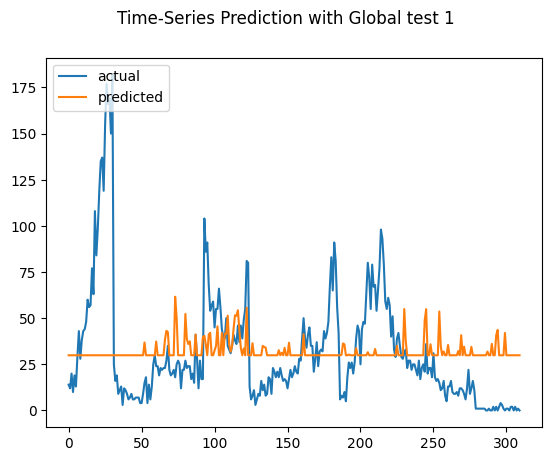

2023-06-15 13:14:07.096034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:14:07.097741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:14:07.099158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_8_input (InputLayer)      [(None, 3, 1022)]    0           []                               
                                                                                                  
 lstm_10_input (InputLayer)     [(None, 3, 28)]      0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 1)            11252971    ['lstm_8_input[0][0]']           
                                                                                                  
 sequential_5 (Sequential)      (None, 1)            7276971     ['lstm_10_input[0][0]']          
                                                                                            

2023-06-15 13:18:38.353119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:18:38.354783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:18:38.356524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 2s 23ms/step
Test MAE: 27.168
Test RMSE: 34.907
Test sMAPE: 81.607
Test R Squared: -0.228
{'mae': 27.168124451175814, 'rmse': 34.90730196736886, 'smape': 81.60686370791922, 'r2': -0.22819549565307695}


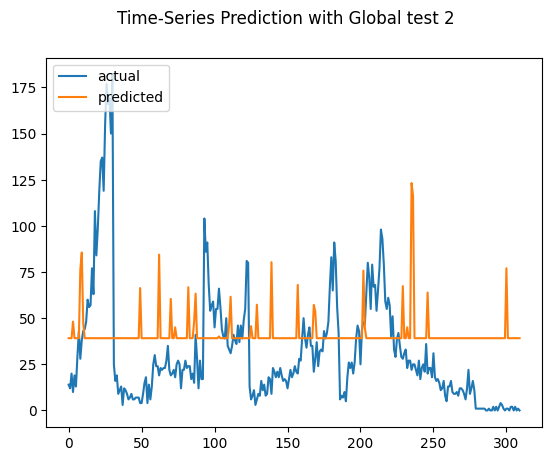

2023-06-15 13:18:40.984894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:18:40.987008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:18:40.988328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_12_input (InputLayer)     [(None, 3, 1022)]    0           []                               
                                                                                                  
 lstm_14_input (InputLayer)     [(None, 3, 28)]      0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 1)            11252971    ['lstm_12_input[0][0]']          
                                                                                                  
 sequential_7 (Sequential)      (None, 1)            7276971     ['lstm_14_input[0][0]']          
                                                                                            

2023-06-15 13:23:06.563192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:23:06.565078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:23:06.566285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 2s 21ms/step
Test MAE: 27.851
Test RMSE: 37.754
Test sMAPE: 81.596
Test R Squared: -0.437
{'mae': 27.851235980372277, 'rmse': 37.75434392510903, 'smape': 81.59633929757868, 'r2': -0.4367089259747101}


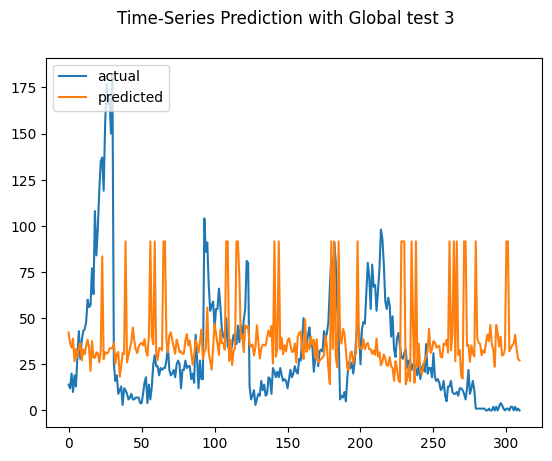

2023-06-15 13:23:08.996230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:23:08.998803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:23:09.001246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_16_input (InputLayer)     [(None, 3, 1022)]    0           []                               
                                                                                                  
 lstm_18_input (InputLayer)     [(None, 3, 28)]      0           []                               
                                                                                                  
 sequential_8 (Sequential)      (None, 1)            11252971    ['lstm_16_input[0][0]']          
                                                                                                  
 sequential_9 (Sequential)      (None, 1)            7276971     ['lstm_18_input[0][0]']          
                                                                                            

2023-06-15 13:27:24.310516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 13:27:24.312730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 13:27:24.313903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 2s 24ms/step
Test MAE: 22.280
Test RMSE: 32.776
Test sMAPE: 74.199
Test R Squared: -0.083
{'mae': 22.28024771290441, 'rmse': 32.775629302027866, 'smape': 74.19929434462908, 'r2': -0.08277198993550217}


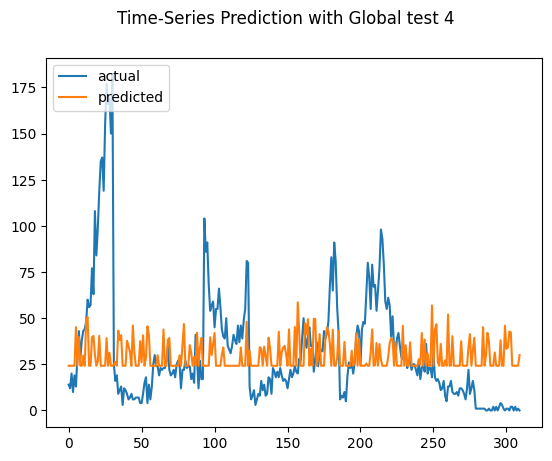

rmse : average=34.262, std=2.028
mae : average=24.281, std=2.654
smape : average=77.828, std=3.262
r2 : average=-0.187, std=0.143


([34.26189954105612, 2.027610833353196],
 [24.28124195714151, 2.6539511963622644],
 [77.82826122794833, 3.2623700555419477],
 [-0.18734289269854432, 0.14268648096933456])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=False, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test)